In [1]:
import collections
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from gensim.parsing.preprocessing import remove_stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

### Tweets sentiment analysis using Naive Bayes
1. Adjust tweets
2. Build dictionary vocabularies
3. Calculate 'lambda' for each word
4. Calculate 'log_prior' & tweets' scores
5. Calculate metrics


#### Data from https://www.kaggle.com/datasets/kazanova/sentiment140

In [2]:
data = pd.read_csv('../data/twitter_sentiment_analysis_data_raw.csv', encoding='latin-1', names=['label', 'id', 'data', 'query', 'author', 'tweet'])

In [3]:
data.loc[data['label']==4, 'label'] = 1
data.label.value_counts()

0    800000
1    800000
Name: label, dtype: int64

In [4]:
data.head()

,label,id,data,query,author,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
def words_stemming(words_list):    
    ps = PorterStemmer()
    stem_words = [ps.stem(word) for word in words_list]
    return stem_words

In [6]:
def reduce_stop_words(words_list):
    text = ' '.join(words_list)
    filtered_sentence = remove_stopwords(text)
    return filtered_sentence.split()

In [7]:
def adjust_tweet(sentence):    
    re_punctuations = r""",|'|\.|!|\?|&|"|:|[|]|;|quot|\\/|\\(|\\)|http\S+|www\S+|@\S+|.com\S+|-|_|=|\+"""        
    words_list = re.sub(re_punctuations, "", sentence.lower()).split()    
    
    words_list = [word for word in words_list if len(word) > 1]        
    
    words_list = words_stemming(words_list)
    
    words_list = reduce_stop_words(words_list)
    
    return ' '.join(words_list)

In [8]:
def txt_to_list(file_name):
    my_file = open(file_name, "r", encoding="utf8")
    content_list = [line.rstrip('\n') for line in my_file.readlines()]
    return content_list

def build_vocabularies_dicts(data, label_col, sentence_col):
    pos_vocabulary = [
        word
        for tweet in data.loc[data[label_col]==1, sentence_col].values.tolist() 
        for word in tweet.split() 
    ]
    
    neg_vocabulary = [
        word
        for tweet in data.loc[data[label_col]==0, sentence_col].values.tolist() 
        for word in tweet.split() 
    ]

    return pos_vocabulary, neg_vocabulary    

In [9]:
def calculate_lambdas(pos_freq, neg_freq):
    df_pos = pd.DataFrame([(k, v) for k, v in pos_freq.items()], columns=['word', 'pos_count'])
    df_neg = pd.DataFrame([(k, v) for k, v in neg_freq.items()], columns=['word', 'neg_count'])
    df_vocabulary = pd.merge(df_pos, df_neg, on='word', how='outer').fillna(0)
    
    df_vocabulary['p_pos'] = (df_vocabulary['pos_count'] + 1) / (df_pos.shape[0] + df_vocabulary.shape[0])
    df_vocabulary['p_neg'] = (df_vocabulary['neg_count'] + 1) / (df_pos.shape[0] + df_vocabulary.shape[0])
    
    df_vocabulary['ratio'] = df_vocabulary['p_pos'] / df_vocabulary['p_neg']
    df_vocabulary['lambda'] = np.log2(df_vocabulary['ratio'])
    
    return df_vocabulary

In [10]:
def calculate_scores(sentence, df_vocabulary, log_prior):
    lambdas_dict = {k: v for k, v in df_vocabulary[['word', 'lambda']].to_numpy().tolist()}
    score = 0
    
    for word in sentence.split():
        score += lambdas_dict.get(word, 0)
    return score + log_prior

# Sampled data

In [11]:
df = data.groupby('label').head(1250).reset_index(drop=True)

In [12]:
train, test = train_test_split(df, test_size=0.7, random_state=42)

### 1. Adjust tweets

In [13]:
train['adjusted_tweet'] = train['tweet'].apply(adjust_tweet)
test['adjusted_tweet'] = test['tweet'].apply(adjust_tweet)
train.head()

,label,id,data,query,author,tweet,adjusted_tweet
132,0,1467842107,Mon Apr 06 22:28:02 PDT 2009,NO_QUERY,wiccabuffy,"@Knights_ No, no notice. They told me I'd be w...",notic told id work tomorrow agenc follow said wa
80,0,1467834053,Mon Apr 06 22:25:52 PDT 2009,NO_QUERY,thelazyboy,sleep soon... i just hate saying bye and see y...,sleep soon hate bye tomorrow night
1586,1,1467881695,Mon Apr 06 22:38:24 PDT 2009,NO_QUERY,JonLanderos,"Ahh, the tedium of fixing broken file links in...",ahh tedium fix broken file link inventor good ...
2157,1,1467987805,Mon Apr 06 23:08:11 PDT 2009,NO_QUERY,Tarale,Had a great lunch with one of my &quot;mums&qu...,great lunch mum today birthday tomorrow got li...
758,0,1467999499,Mon Apr 06 23:11:30 PDT 2009,NO_QUERY,jj_1983,Back at work @ John Muir Dr http://loopt.us/K...,work john muir dr


### 2. Create vocabulary dictionaries

In [14]:
pos_vocabulary, neg_vocabulary = build_vocabularies_dicts(train, 'label', 'adjusted_tweet')
neg_freq = collections.Counter(x for x in neg_vocabulary)
pos_freq = collections.Counter(x for x in pos_vocabulary)

### 3. Calculate words lambda values

In [15]:
df_vocabulary = calculate_lambdas(pos_freq, neg_freq)
df_vocabulary.loc[df_vocabulary['pos_count'] == 0].head(5)

,word,pos_count,neg_count,p_pos,p_neg,ratio,lambda
1324,agenc,0.0,2.0,0.000285,0.000856,0.333333,-1.584963
1325,bye,0.0,1.0,0.000285,0.000571,0.500000,-1.000000
1326,john,0.0,2.0,0.000285,0.000856,0.333333,-1.584963
1327,muir,0.0,1.0,0.000285,0.000571,0.500000,-1.000000
1328,suck,0.0,5.0,0.000285,0.001712,0.166667,-2.584963


### 4. Calculate 'log_prior' and tweet scores

In [16]:
log_prior = np.log(train.loc[train['label'] == 1].shape[0] / train.loc[train['label'] == 0].shape[0])
test['score'] = test['adjusted_tweet'].apply(calculate_scores, args=(df_vocabulary, log_prior))
test['pred'] = (test['score'] > 0).astype(int)
test.head()

,label,id,data,query,author,tweet,adjusted_tweet,score,pred
1447,1,1467861286,Mon Apr 06 22:32:57 PDT 2009,NO_QUERY,llliizzziiiee,@Westneyrhindxx hello westney what are you do...,hello westney,-0.016000,0
1114,0,1468083884,Mon Apr 06 23:37:29 PDT 2009,NO_QUERY,pstannard1,"got woken up this mornng at 7am - damn Lorry ,...",got woken thi mornng 7am damn lorri van car ac...,-7.426817,0
1064,0,1468072530,Mon Apr 06 23:33:55 PDT 2009,NO_QUERY,SarahDeG,Why do I keep looking...I know that what I rea...,whi lookingi know read gonna hurt look guess g...,-2.587157,0
2287,1,1468007017,Mon Apr 06 23:13:40 PDT 2009,NO_QUERY,Hetty4Christ,Pray for my friend @growline late work...pray ...,pray friend late workpray goe wellwith energi ...,3.144464,1
1537,1,1467864444,Mon Apr 06 22:33:48 PDT 2009,NO_QUERY,elysemize,@JonathanRKnight i do embrace the simple life...,embrac simpl life simpl thing like new kid reu...,-0.659022,0


### 5. Results

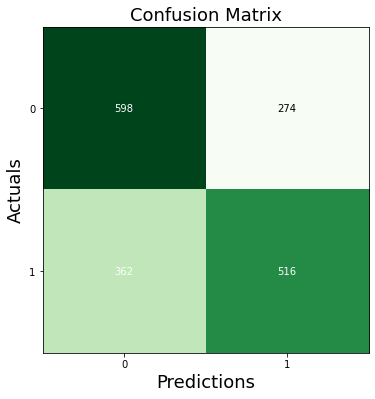

In [17]:
conf_mat = confusion_matrix(test['label'], test['pred'])
fig, ax = plot_confusion_matrix(conf_mat=conf_mat, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()


In [18]:
logreg=accuracy_score(test['label'], test['pred'])
logreg

0.6365714285714286

In [19]:
roc_auc_score(test['label'], test['pred'])

0.6367395665712314

In [20]:
print(metrics.classification_report(test['label'], test['pred']))

              precision    recall  f1-score   support

           0       0.62      0.69      0.65       872
           1       0.65      0.59      0.62       878

    accuracy                           0.64      1750
   macro avg       0.64      0.64      0.64      1750
weighted avg       0.64      0.64      0.64      1750



# Using all data

In [21]:
df = data
df.label.value_counts()

0    800000
1    800000
Name: label, dtype: int64

In [22]:
train, test = train_test_split(df, test_size=0.7, random_state=42)

train['adjusted_tweet'] = train['tweet'].apply(adjust_tweet)
test['adjusted_tweet'] = test['tweet'].apply(adjust_tweet)

pos_vocabulary, neg_vocabulary = build_vocabularies_dicts(train, 'label', 'adjusted_tweet')
neg_freq = collections.Counter(x for x in neg_vocabulary)
pos_freq = collections.Counter(x for x in pos_vocabulary)

In [23]:
df_vocabulary = calculate_lambdas(pos_freq, neg_freq)

In [ ]:
log_prior = np.log(train.loc[train['label'] == 1].shape[0] / train.loc[train['label'] == 0].shape[0])
test['score'] = test['adjusted_tweet'].apply(calculate_scores, args=(df_vocabulary, log_prior))
test['pred'] = (test['score'] > 0).astype(int)

In [ ]:
conf_mat = confusion_matrix(test['label'], test['pred'])
fig, ax = plot_confusion_matrix(conf_mat=conf_mat, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
logreg=accuracy_score(test['label'], test['pred'])
logreg

In [ ]:
roc_auc_score(test['label'], test['pred'])

In [ ]:
print(metrics.classification_report(test['label'], test['pred']))